In [ ]:
import random
import string
from typing import Optional, Literal, Any, Type
import numpy as np

import torch
import torch.nn.functional as F
from torch import Tensor

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd
from dataclasses import dataclass, field

torch.set_printoptions(linewidth=120)
seed = 2**31 - 1

<hr>

# Activations, Gradients and Batch Normalisation - Part 2
<hr>

This notebook will focus on organizing our code into modules, allowing us to build neural networks in a similar way to pytorch while maintaining a consistent API. Our approach involves creating a Linear layer module and a BatchNorm1d module, which we will use to reconstruct our neural net. Once our network is built, we will train it in the same manner as before.

Next, we will examine activation statistics during both the forward and backward passes. Finally, we will proceed with evaluation and sampling, following the same approach as in previous iterations.

## Setup

**Load the data**

In [2]:
# Load the data
with open('./data/names.txt', 'r') as f:
    names = f.read().splitlines()
print(f'Total # names: {len(names):.>25,}')
print(f"Total # characters in all names: {len(''.join(names)):,}")
print(names[:5])

Total # names: ...................32,033
Total # characters in all names: 196,113
['emma', 'olivia', 'ava', 'isabella', 'sophia']


**Encoding and decoding characters**   
We define an encoder `ch2ix` and decoder `ix2ch` function that maps a character with a numerical representation (i.e. a unique integer) and vice-versa. 

In [3]:
chars = '.' + string.ascii_lowercase
ch2ix = {s: i for i, s in enumerate(chars)}
ix2ch = {i: s for s, i in ch2ix.items()}
vocab_size = len(ix2ch)

print('Encoder ch2ix:\n', ch2ix)
print('Decoder ix2ch:\n', ix2ch)
print('E.g. emma:', [ch2ix[c] for c in '.emma.'])

Encoder ch2ix:
 {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
Decoder ix2ch:
 {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
E.g. emma: [0, 5, 13, 13, 1, 0]


**Build the datasets**

In [4]:
def make_dataset(words, block_size=3) -> tuple[Tensor, Tensor]:
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = ch2ix[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(f'Shape (X, Y): {X.shape}, {Y.shape}')
    return X, Y

In [5]:
words = names.copy()
random.seed(42)
random.shuffle(words)

n = len(words)
n1 = int(0.8 * n)
n2 = int(0.9 * n)
Xtrn, Ytrn = make_dataset(words[:n1])
Xval, Yval = make_dataset(words[n1:n2])
Xtst, Ytst = make_dataset(words[n2:])


Shape (X, Y): torch.Size([182625, 3]), torch.Size([182625])
Shape (X, Y): torch.Size([22655, 3]), torch.Size([22655])
Shape (X, Y): torch.Size([22866, 3]), torch.Size([22866])


## Modules

We will generate modules for Linear, BatchNorm1d, and Tanh that we can subsequently combine to form layers in our neural network.

### Linear

[`torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)

Applies a linear transformation to the incoming data: $y=xA^T+b$

In [6]:
class Linear:
    def __init__(self, in_features: int, out_features: int, bias: bool = True, seed: int | None = None) -> None:
        g = torch.Generator().manual_seed(seed) if seed else None
        self.use_bias = bias
        self.weight = torch.randn((in_features, out_features), generator=g)
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x: Tensor) -> Tensor:
        x = x @ self.weight
        if self.use_bias:
            x += self.bias
        self.out = x  # To be able to access x for plotting
        return self.out

    def parameters(self) -> list:
        return [self.weight] + ([self.bias] if self.use_bias else [])


### BatchNorm1d

[`torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)`](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html#torch.nn.BatchNorm1d)

Applies Batch Normalization over a 2D or 3D input as described in the paper Batch Normalization: [Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167).

$y=\Large{\frac{x-\mathrm{E}[x]}{\sqrt{\mathrm{Var}[x]+\epsilon}}}\normalsize{*\gamma+\beta}$  

In [7]:
class BatchNorm1d:
    def __init__(self, num_features: int, eps: float = 1e-5, momentum: float = 0.1) -> None:
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Trainable parameters
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        # Running stats trained with 'momentum update'
        self.running_mean = torch.zeros(num_features)
        self.running_std = torch.ones(num_features)
        self.out = torch.Tensor()  # To be able to access x for plotting

    def __call__(self, x: Tensor) -> Tensor:
        if self.training:
            x_mean = x.mean(0, keepdim=True)
            x_std = torch.sqrt(x.var(0, keepdim=True) + self.eps)
        else:
            x_mean = self.running_mean
            x_std = self.running_std

        x = (x - x_mean) / x_std
        x = x * self.gamma + self.beta
        # Update running stats
        if self.training:
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * x_mean
            self.running_std = (1 - self.momentum) * self.running_std + self.momentum * x_std

        self.out = x  # To be able to access x for plotting
        return self.out

    def parameters(self) -> list[Tensor]:
        return [self.gamma, self.beta]

### Tanh

In [8]:
class Tanh:
    def __call__(self, x) -> Tensor:
        x = torch.tanh(x)
        self.out = x  # To be able to access x for plotting
        return self.out

    def parameters(self) -> list:
        return []


## MLP

In [9]:
class MLP:
    def __init__(
        self, layers: list, vocab_size: int = 27, block_size: int = 3, emb_dim: int = 10, hid_dim: int = 100, seed: int | None = None
    ) -> None:
        g = torch.Generator().manual_seed(seed) if seed else None
        self.layers = layers
        self.block_size = block_size
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.C = torch.randn((vocab_size, emb_dim), generator=g)  # Embedding

        self.parameters = [self.C] + [p for layer in layers for p in layer.parameters()]
        for p in self.parameters:
            p.requires_grad = True
        self.n_parameters = sum(p.nelement() for p in self.parameters)

    def __call__(self, xs: Tensor) -> Tensor:
        y_hat = self.C[xs]  # (bs, 3, 10) Embed characters into vectors
        y_hat = y_hat.view(-1, self.block_size * self.emb_dim)  # (bs, 30) Concatenate the vectors
        for layer in self.layers:
            y_hat = layer(y_hat)
        return y_hat

    def zero_grad(self) -> None:
        """Sets the gradients to None"""
        for p in self.parameters:
            p.grad = None

    def optimise_step(self, lr) -> None:
        """Updat the parameters"""
        for p in self.parameters:
            p.data += -lr * p.grad

In [10]:
def create_layers(n_layers: int = 6, block_size: int = 3, n_emb: int = 10, n_hidden: int = 100, use_bn: bool = False, seed: int = seed) -> list:
    # 1st linear layer
    layers = [Linear(n_emb * block_size, n_hidden, seed=seed)]
    if use_bn:
        layers += [BatchNorm1d(n_hidden)]
    layers += [Tanh()]
    # Hidden layers
    for i in range(n_layers - 2):
        layers += [Linear(n_hidden, n_hidden, seed=seed)]
        if use_bn:
            layers += [BatchNorm1d(n_hidden)]
        layers += [Tanh()]
    # Output layer
    layers += [Linear(n_hidden, vocab_size, seed=seed)]
    return layers


def init_weights(layers: list, gain: float = 5 / 3) -> None:
    # 5/3 -> Kaiming initialisation for Tanh activation
    with torch.no_grad():
        # Make last layer less confident
        layers[-1].weight *= 0.1  # /sqrt(100)
        # Apply gain for on other layers
        for layer in layers[:-1]:
            if isinstance(layer, Linear):
                in_features = layer.weight.shape[0]
                layer.weight *= gain / in_features**0.5

In [11]:
def train(model: MLP, layers: list, n_steps: int = 200000, bs: int = 32, lr: float = 0.1, seed: int | None = None) -> tuple[list, list]:
    g = torch.Generator().manual_seed(seed) if seed else None

    losses = []
    uwr = []  # Update to weights ratio
    for i in range(n_steps):
        # Minibatch construct
        ix = torch.randint(0, Xtrn.shape[0], (bs,), generator=g)
        Xb, Yb = Xtrn[ix], Ytrn[ix]

        # Forward pass
        logits = model(Xb)
        loss = F.cross_entropy(logits, Yb)

        # Backward pass
        for layer in layers:
            layer.out.retain_grad()
        model.zero_grad()
        loss.backward()

        # Update
        lr = lr if i < 100000 else lr / 10  # Step learning rate decay
        model.optimise_step(lr)

        # Tack stats
        if i % 10000 == 0:
            print(f'{i:7d}/{n_steps}: {loss.item():.4f}')
        losses.append(loss.log10().item())
        with torch.no_grad():
            uwr.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in model.parameters if p.grad is not None])
    return losses, uwr


## Diagnostic tools

### Activation distribution

In [12]:
def plt_activations_hist(layers: list, layer_type: Type[Linear | Tanh | BatchNorm1d]) -> None:
    plt.figure(figsize=(10, 4))
    legends = []
    for i, layer in enumerate(layers[:-1]):  # All layers except last softmax layer
        if isinstance(layer, layer_type):
            t = layer.out
            sat = (t.abs() > 0.97).float().mean() * 100  # % of saturated neurons
            print(f'layer {i} | {layer.__class__.__name__:<12} | mean: {t.mean():+.2f} | std: {t.std():.2f} | saturated: {sat:5.2f}%')
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'layer {i}')
    plt.legend(legends)
    plt.title(f'{layer_type.__name__} Activation Distribution')
    plt.show()

### Activation gradients

In [13]:
def plt_gradients_hist(layers: list, layer_type: Type[Linear | Tanh | BatchNorm1d]) -> None:
    plt.figure(figsize=(10, 4))
    legends = []
    for i, layer in enumerate(layers[:-1]):  # All layers except last softmax layer
        if isinstance(layer, layer_type):
            t = layer.out.grad
            if t is not None:
                print(f'layer {i} | {layer.__class__.__name__:<12} | mean: {t.mean():+.2f} | std: {t.std():.4e}')
                hy, hx = torch.histogram(t, density=True)
                plt.plot(hx[:-1].detach(), hy.detach())
                legends.append(f'layer {i}')
    plt.legend(legends)
    plt.title(f'{layer_type.__name__} Gradient Distribution')
    plt.show()


### Weight gradients

In [14]:
def plt_weights_gradients(model: MLP) -> None:
    plt.figure(figsize=(10, 4))
    legends = []
    parameters = model.parameters
    for i, p in enumerate(parameters):
        t = p.grad
        if p.ndim == 2 and t is not None:
            print(f'{i:>5} | weight: {str(tuple(p.shape)):>10} | mean: {t.mean():+.2f} | std: {t.std():.4e} | grad:data ratio: {t.std()/p.std():.4e}')
            hy, hx = torch.histogram(t, density=True)
            plt.plot(hx[:-1].detach(), hy.detach())
            legends.append(f'{i} {tuple(p.shape)}')
    plt.legend(legends)
    plt.title(f'Weights Gradient Distribution')
    plt.show()

### Update weights ratio

In [15]:
def plt_update_weights_ratio(model: MLP, uwr: list[list[float]]) -> None:
    plt.figure(figsize=(10, 4))
    legends = []
    parameters = model.parameters
    for i, p in enumerate(parameters):
        if p.ndim == 2:  # Only the weights
            plt.plot([uwr[j][i] for j in range(len(uwr))])
            legends.append(f'Param {i}')
    plt.plot([0, len(uwr)], [-3, -3], lw=3, ls='--', c='r')  # ~1e-3 is roughly the ideal ratio => plot -3 (log10)
    plt.legend(legends)
    plt.title(f'Update to Data Ratio')


## Initialisation gain

To evaluate the impact of initialization gain on a neural network's performance, we will train the network using various gain values.

In [16]:
# ---------------------------------------------------------------------
# Model Parameters
block_size = 3
n_emb = 10  # The dim of the embedding vector
n_hidden = 100  # The nr of neurons in the hidden layer
n_layers = 6
# ---------------------------------------------------------------------
# Training parameters
n_steps = 1
bs = 32

### Correct initialisation gain (5/3) 

In [17]:
use_bn = False
gain = 5 / 3
lr = 0.1

layers = create_layers(n_layers=n_layers, block_size=block_size, n_emb=n_emb, n_hidden=n_hidden, use_bn=use_bn, seed=seed)
init_weights(layers=layers, gain=gain)
model = MLP(layers=layers, block_size=block_size, emb_dim=n_emb, hid_dim=n_hidden, seed=seed)
print(f'Nr. parameters: {model.n_parameters}')
losses, uwr = train(model=model, layers=layers, n_steps=n_steps, bs=bs, lr=lr, seed=seed)

Nr. parameters: 46497
      0/1: 3.3254


layer 1 | Tanh         | mean: +0.03 | std: 0.75 | saturated: 20.56%
layer 3 | Tanh         | mean: -0.01 | std: 0.68 | saturated:  7.88%
layer 5 | Tanh         | mean: +0.02 | std: 0.65 | saturated:  6.59%
layer 7 | Tanh         | mean: +0.04 | std: 0.64 | saturated:  4.53%
layer 9 | Tanh         | mean: +0.00 | std: 0.63 | saturated:  3.97%


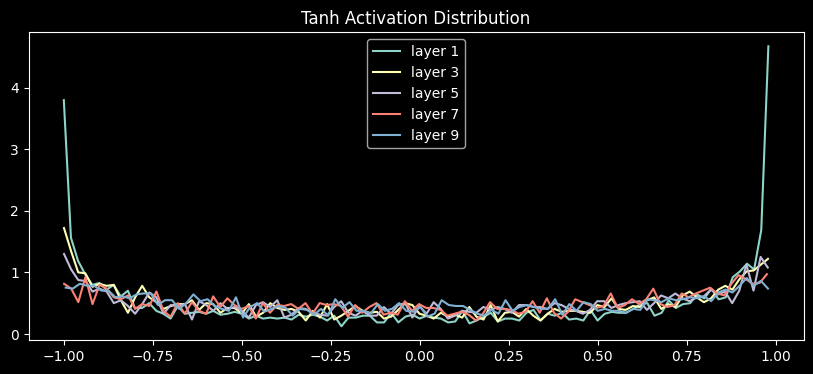

layer 1 | Tanh         | mean: -0.00 | std: 4.6075e-03
layer 3 | Tanh         | mean: -0.00 | std: 4.2899e-03
layer 5 | Tanh         | mean: -0.00 | std: 3.7575e-03
layer 7 | Tanh         | mean: +0.00 | std: 3.4078e-03
layer 9 | Tanh         | mean: +0.00 | std: 3.0632e-03


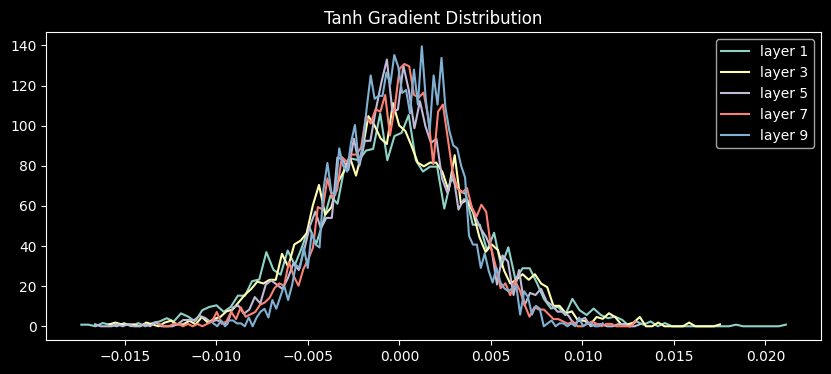

In [18]:
plt_activations_hist(layers, Tanh)
plt_gradients_hist(layers, Tanh)

### Too low initialisation gain (1) 

In [19]:
use_bn = False
gain = 1  # 5 / 3
layers = create_layers(n_layers=n_layers, block_size=block_size, n_emb=n_emb, n_hidden=n_hidden, use_bn=use_bn, seed=seed)
init_weights(layers=layers, gain=gain)
model = MLP(layers=layers, block_size=block_size, emb_dim=n_emb, hid_dim=n_hidden, seed=seed)
print(f'Nr. parameters: {model.n_parameters}')

losses, uwr = train(model=model, layers=layers, n_steps=n_steps, bs=bs, seed=seed)


Nr. parameters: 46497
      0/1: 3.1976


layer 1 | Tanh         | mean: +0.03 | std: 0.62 | saturated:  4.00%
layer 3 | Tanh         | mean: -0.01 | std: 0.47 | saturated:  0.00%
layer 5 | Tanh         | mean: +0.01 | std: 0.39 | saturated:  0.00%
layer 7 | Tanh         | mean: +0.02 | std: 0.33 | saturated:  0.00%
layer 9 | Tanh         | mean: +0.00 | std: 0.29 | saturated:  0.00%


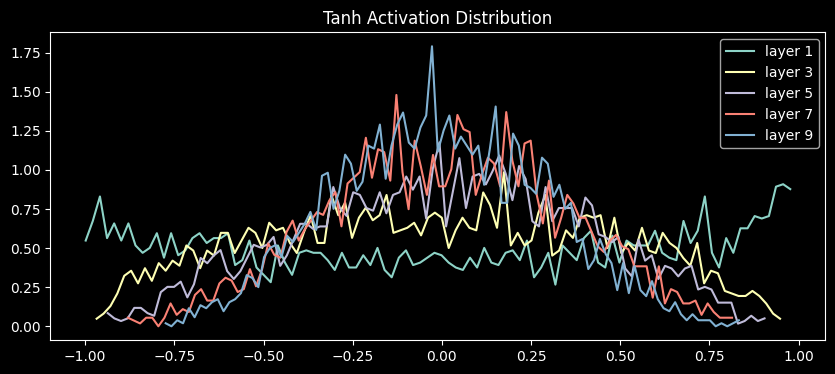

layer 1 | Tanh         | mean: -0.00 | std: 1.7376e-03
layer 3 | Tanh         | mean: -0.00 | std: 2.1532e-03
layer 5 | Tanh         | mean: -0.00 | std: 2.4328e-03
layer 7 | Tanh         | mean: +0.00 | std: 2.8186e-03
layer 9 | Tanh         | mean: +0.00 | std: 3.0382e-03


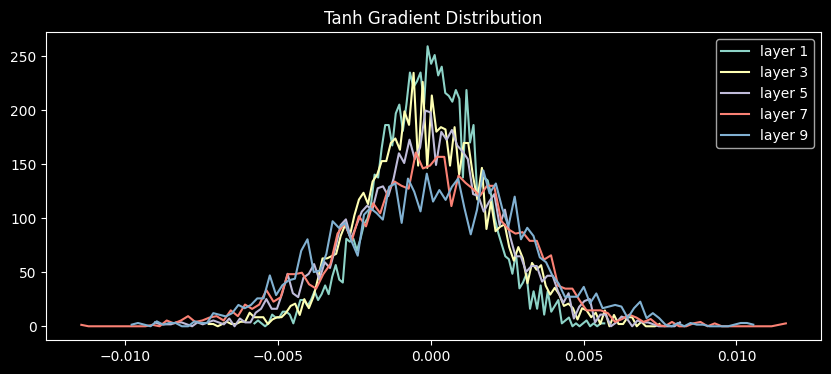

In [20]:
plt_activations_hist(layers, Tanh)
plt_gradients_hist(layers, Tanh)


### Too high initialisation gain (3) 

In [21]:
use_bn = False
gain = 3  # 5 / 3

layers = create_layers(n_layers=n_layers, block_size=block_size, n_emb=n_emb, n_hidden=n_hidden, use_bn=use_bn, seed=seed)
init_weights(layers=layers, gain=gain)
model = MLP(layers=layers, block_size=block_size, emb_dim=n_emb, hid_dim=n_hidden, seed=seed)
print(f'Nr. parameters: {model.n_parameters}')
losses, uwr = train(model=model, layers=layers, n_steps=n_steps, bs=bs, seed=seed)


Nr. parameters: 46497
      0/1: 3.5164


layer 1 | Tanh         | mean: +0.04 | std: 0.86 | saturated: 47.03%
layer 3 | Tanh         | mean: -0.01 | std: 0.84 | saturated: 40.16%
layer 5 | Tanh         | mean: +0.02 | std: 0.83 | saturated: 39.16%
layer 7 | Tanh         | mean: +0.04 | std: 0.83 | saturated: 38.16%
layer 9 | Tanh         | mean: +0.01 | std: 0.83 | saturated: 38.44%


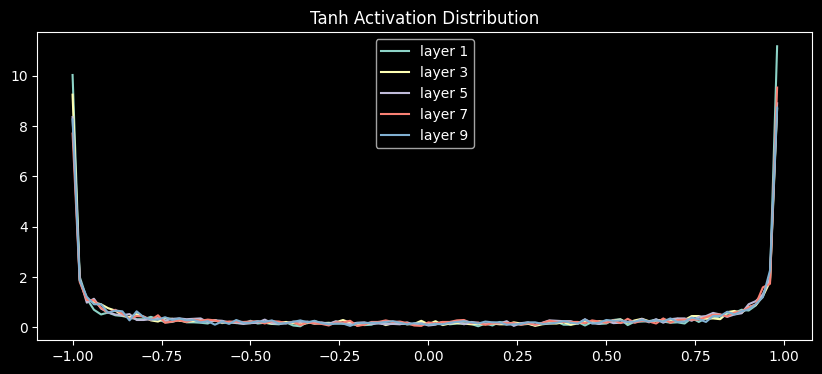

layer 1 | Tanh         | mean: +0.00 | std: 1.1001e-02
layer 3 | Tanh         | mean: -0.00 | std: 7.9926e-03
layer 5 | Tanh         | mean: +0.00 | std: 5.6239e-03
layer 7 | Tanh         | mean: -0.00 | std: 4.2310e-03
layer 9 | Tanh         | mean: +0.00 | std: 3.1050e-03


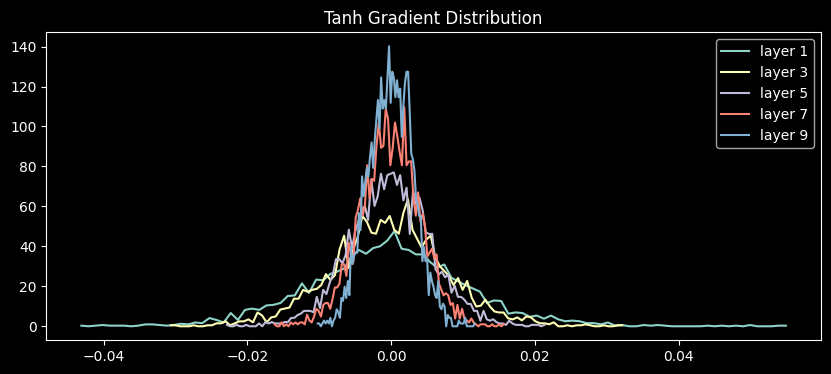

In [22]:
plt_activations_hist(layers, Tanh)
plt_gradients_hist(layers, Tanh)


#### Conclusion

**If we set the gain to the correct value of 5/3:**  
Activations:  
- Layer 1 is fairly saturated at ~21%. This is visible in the plot at the values around -1 and 1.
- Other layers are not very saturated (~5%). The reason is because we set the gain to 5/3.

Gradients:
- The gradients of each layer are roughly the same.

**If we set the gain too low (1):**   
Activations:  
- Layer 1 is decent. 
- As more layers are traversed, the activation distributions are increasingly squeezed towards 0. Increasing the gain will help preventing this squeezing.  

Gradients:  
- As more layers are traversed, the variance of the gradient distributions increases.

**If we set the gain too high (3):**   
Activations:  
- The saturations of all layers are way too high.

Gradients:
- The variance of the gradient distributions decrease as more layers are traversed.

## Batch normalisation

To evaluate the impact of initialization gain on a neural network's performance, we will train the network using various gain values.

In [74]:
# ---------------------------------------------------------------------
# Model Parameters
block_size = 3
n_emb = 10  # The dim of the embedding vector
n_hidden = 100  # The nr of neurons in the hidden layer
n_layers = 6
# ---------------------------------------------------------------------
# Training parameters
n_steps = 1000
bs = 32
lr = 0.1

### Correct initialisation gain (5/3) 

In [75]:
use_bn = True
gain = 5 / 3

layers = create_layers(n_layers=n_layers, block_size=block_size, n_emb=n_emb, n_hidden=n_hidden, use_bn=use_bn, seed=seed)
init_weights(layers=layers, gain=gain)
model = MLP(layers=layers, block_size=block_size, emb_dim=n_emb, hid_dim=n_hidden, seed=seed)
print(f'Nr. parameters: {model.n_parameters}')
losses, uwr = train(model=model, layers=layers, n_steps=n_steps, bs=bs, lr=lr, seed=seed)

Nr. parameters: 47497
      0/1000: 3.3349


layer 2 | Tanh         | mean: +0.00 | std: 0.64 | saturated:  2.84%
layer 5 | Tanh         | mean: +0.01 | std: 0.64 | saturated:  2.22%
layer 8 | Tanh         | mean: +0.01 | std: 0.65 | saturated:  2.19%
layer 11 | Tanh         | mean: +0.01 | std: 0.65 | saturated:  1.97%
layer 14 | Tanh         | mean: +0.01 | std: 0.65 | saturated:  1.66%


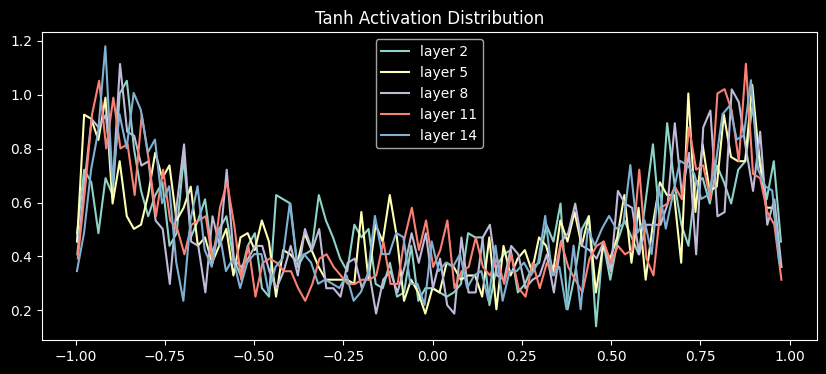

layer 2 | Tanh         | mean: +0.00 | std: 4.2741e-03
layer 5 | Tanh         | mean: -0.00 | std: 3.6387e-03
layer 8 | Tanh         | mean: +0.00 | std: 3.3256e-03
layer 11 | Tanh         | mean: +0.00 | std: 3.1141e-03
layer 14 | Tanh         | mean: +0.00 | std: 3.2100e-03


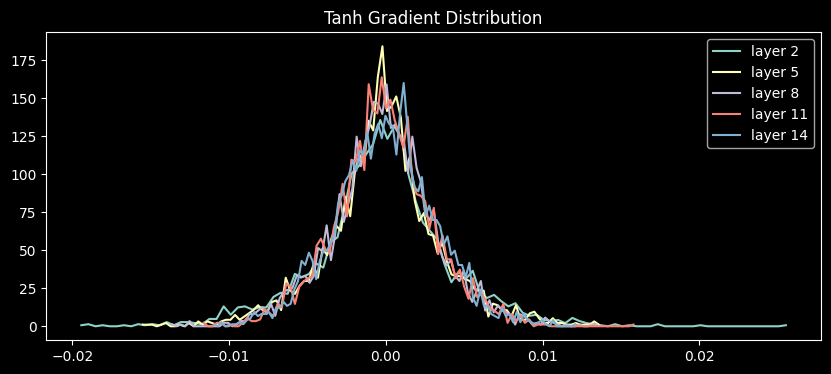

In [76]:
plt_activations_hist(layers, Tanh)
plt_gradients_hist(layers, Tanh)

### Too low initialisation gain (1) 

In [77]:
use_bn = True
gain = 1  # 5 / 3
layers = create_layers(n_layers=n_layers, block_size=block_size, n_emb=n_emb, n_hidden=n_hidden, use_bn=use_bn, seed=seed)
init_weights(layers=layers, gain=gain)
model = MLP(layers=layers, block_size=block_size, emb_dim=n_emb, hid_dim=n_hidden, seed=seed)
print(f'Nr. parameters: {model.n_parameters}')

losses, uwr = train(model=model, layers=layers, n_steps=n_steps, bs=bs, seed=seed)


Nr. parameters: 47497
      0/1000: 3.3349


layer 2 | Tanh         | mean: +0.00 | std: 0.63 | saturated:  2.91%
layer 5 | Tanh         | mean: +0.00 | std: 0.64 | saturated:  2.66%
layer 8 | Tanh         | mean: +0.01 | std: 0.65 | saturated:  2.09%
layer 11 | Tanh         | mean: -0.00 | std: 0.65 | saturated:  2.09%
layer 14 | Tanh         | mean: +0.00 | std: 0.66 | saturated:  1.16%


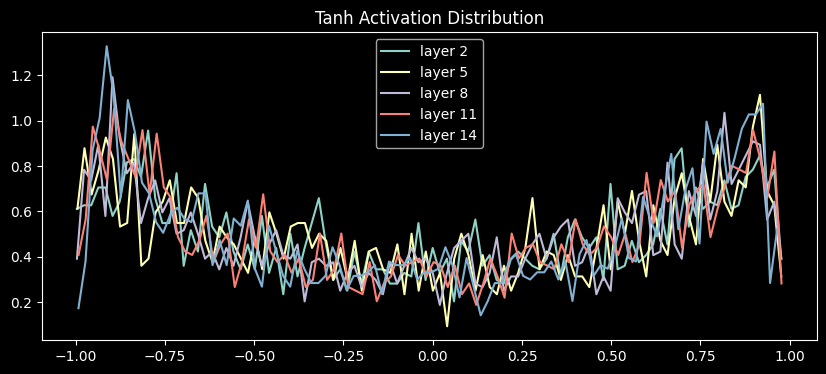

layer 2 | Tanh         | mean: +0.00 | std: 3.3701e-03
layer 5 | Tanh         | mean: +0.00 | std: 2.8153e-03
layer 8 | Tanh         | mean: +0.00 | std: 2.6370e-03
layer 11 | Tanh         | mean: -0.00 | std: 2.4682e-03
layer 14 | Tanh         | mean: +0.00 | std: 3.0869e-03


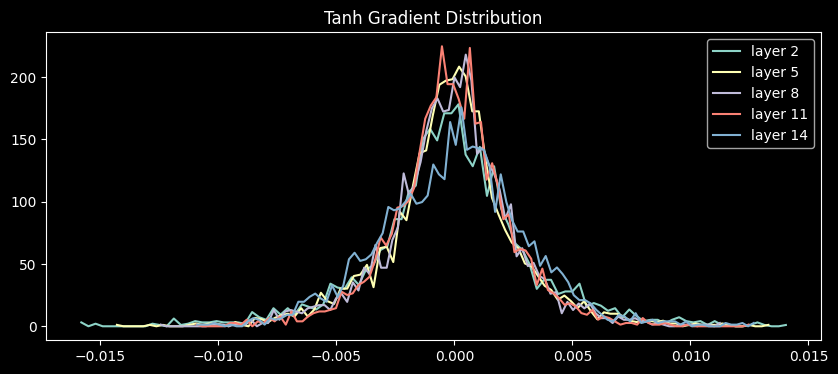

In [78]:
plt_activations_hist(layers, Tanh)
plt_gradients_hist(layers, Tanh)


### Too high initialisation gain (3) 

In [79]:
use_bn = True
gain = 3  # 5 / 3

layers = create_layers(n_layers=n_layers, block_size=block_size, n_emb=n_emb, n_hidden=n_hidden, use_bn=use_bn, seed=seed)
init_weights(layers=layers, gain=gain)
model = MLP(layers=layers, block_size=block_size, emb_dim=n_emb, hid_dim=n_hidden, seed=seed)
print(f'Nr. parameters: {model.n_parameters}')
losses, uwr = train(model=model, layers=layers, n_steps=n_steps, bs=bs, seed=seed)


Nr. parameters: 47497
      0/1000: 3.3349


layer 2 | Tanh         | mean: +0.00 | std: 0.63 | saturated:  2.72%
layer 5 | Tanh         | mean: +0.01 | std: 0.64 | saturated:  2.69%
layer 8 | Tanh         | mean: +0.00 | std: 0.64 | saturated:  2.44%
layer 11 | Tanh         | mean: +0.00 | std: 0.64 | saturated:  1.84%
layer 14 | Tanh         | mean: +0.00 | std: 0.64 | saturated:  2.34%


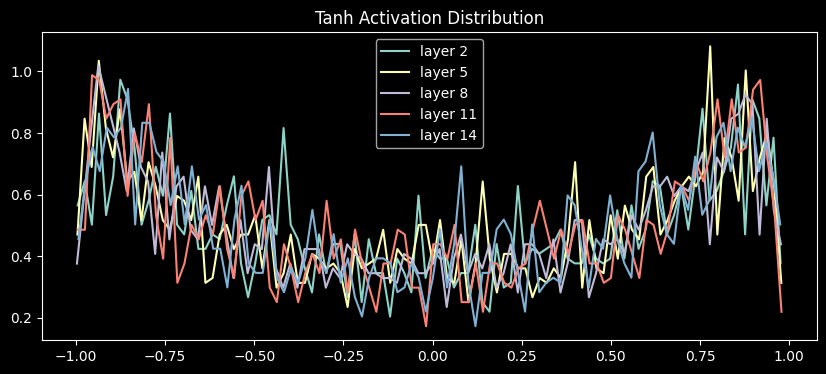

layer 2 | Tanh         | mean: +0.00 | std: 5.0882e-03
layer 5 | Tanh         | mean: -0.00 | std: 4.3340e-03
layer 8 | Tanh         | mean: +0.00 | std: 3.8639e-03
layer 11 | Tanh         | mean: -0.00 | std: 3.5354e-03
layer 14 | Tanh         | mean: +0.00 | std: 3.4085e-03


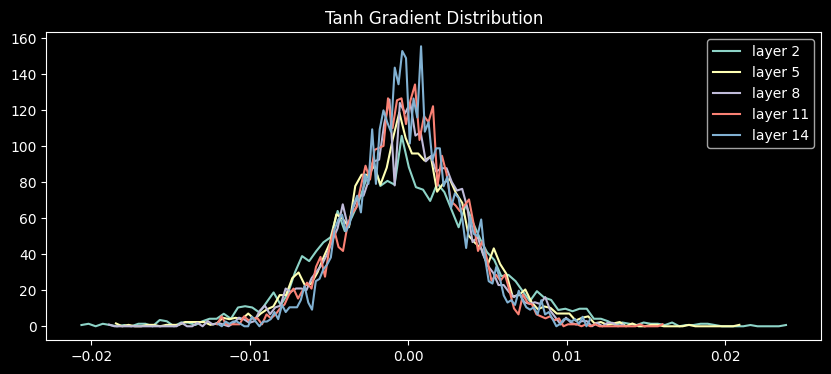

In [80]:
plt_activations_hist(layers, Tanh)
plt_gradients_hist(layers, Tanh)


### Conclusions

We can observe that adding batch normalization layers to a neural network results in well-behaved activations and gradients, even when the initialization gain is not optimal. The use of batch normalization makes the neural network less sensitive to initial conditions, which can simplify the process of finding a good initialization.

### Weight 

    0 | weight:   (27, 10) | mean: -0.00 | std: 1.3109e-02 | grad:data ratio: 1.3089e-02
    1 | weight:  (30, 100) | mean: -0.00 | std: 6.4590e-03 | grad:data ratio: 1.1654e-02
    5 | weight: (100, 100) | mean: +0.00 | std: 6.0543e-03 | grad:data ratio: 2.0028e-02
    9 | weight: (100, 100) | mean: +0.00 | std: 5.1148e-03 | grad:data ratio: 1.6930e-02
   13 | weight: (100, 100) | mean: +0.00 | std: 4.3957e-03 | grad:data ratio: 1.4554e-02
   17 | weight: (100, 100) | mean: +0.00 | std: 3.7799e-03 | grad:data ratio: 1.2517e-02
   21 | weight:  (100, 27) | mean: +0.00 | std: 2.1064e-02 | grad:data ratio: 1.9037e-01


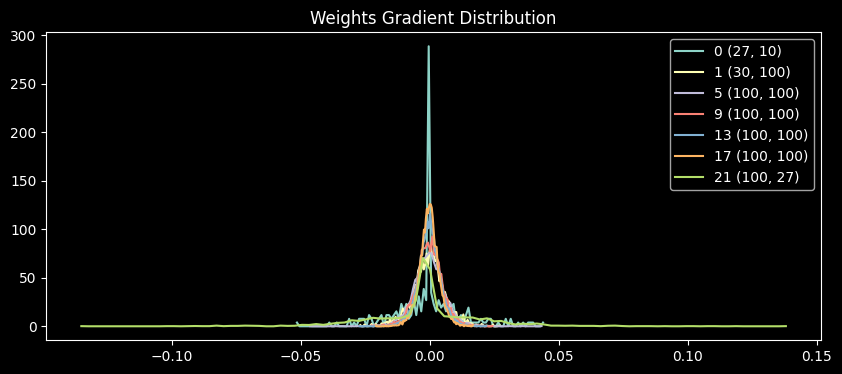

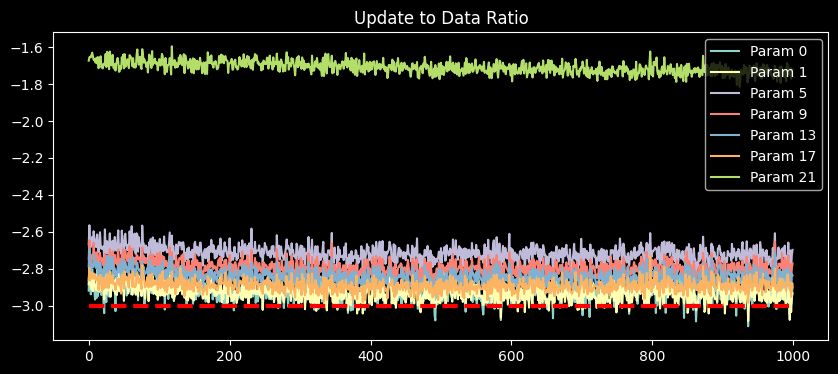

In [81]:
plt_weights_gradients(model)
plt_update_weights_ratio(model, uwr)